# IV HACKDAY CDS

### APRESENTAÇÃO FINAL - EQUIPE 08 - DSemFronteiras
<br>

**MEMBROS DA EQUIPE:**
- **André Luis**, diretin de Minas, uai
- **Marcio Bouhid**, direto da copacabana de Portugal, ora poixx
- **Michele Lopes**, direto de Itajaí com conexão em SP e um pé no Chi Chi Chi, Le Le Le
- **Rodrigo Cruz**, direto de Belém, mas não a do menino Jesus
- **Victor Brasil**, direto do interior do interior da Grande SP (ABC), meoooo

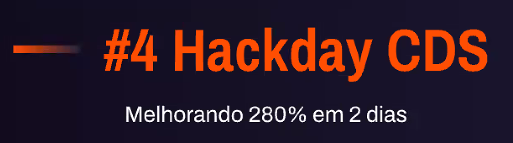

In [1]:
from IPython.display      import Image
Image('../images/banner_hd.png')

# Hotel Chain Cancellation Rating

### Agenda

    1. Contexto
    2. Desafio
    3. Desenvolvimento da Solução
    4. Conclusão
    5. Próximos passos

### Contexto


- Rede hoteleira espanhola Costa del Data, possui hotéis de 4 e 5 estrelas. 

- Com a reabertura pós-Covid, houve um aumento na taxa de cancelamento, diferente do que era esperado pelo setor.

- Vale ressaltar que a Espanha está entre os maiores países afetados pela pandemia e possuem mais de 10% de participação do setor de viagens em suas economias.

- A empresa suspendeu ações estratégicas críticas como:
        
        - Expansão da rede hoteleira
        - Reforma das unidades com obras já programadas
        - Ações de marketing direcionadas

### Desafio


- Quais são os principais insights acionáveis para a empresa Costa del Data, em relação ao comportamento dos clientes? 

- Qual é a previsão de cancelamentos dos clientes? 

- Qual o público com menor incidência de cancelamento para que o cenário possa ser revertido?

# DESENVOLVIMENTO DA SOLUÇÃO

## IMPORTS

### Libs

In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

import inflection
import unicodedata

from IPython.display      import Image
from IPython.core.display import HTML

from sklearn.metrics         import f1_score, make_scorer
from sklearn.ensemble        import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.preprocessing   import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from category_encoders.count import CountEncoder
from sklearn.model_selection import train_test_split, cross_val_score

import warnings
warnings.filterwarnings( 'ignore' )

### Helper Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.rcParams['font.size'] = 24
    sns.set_palette("Reds") 
    
    display(HTML( '<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [4]:
jupyter_settings()

### Carregamento dos Dados

In [5]:
# Leitura dos datasets de treino e teste (submissão)
train = pd.read_csv('../inputs/train.csv', encoding='utf-8')
test = pd.read_csv('../inputs/test.csv',  encoding='utf-8')

| Variável | Definição |
| --- | --- |
|id | Código único de identificação do cliente |
|Classificação do hotel | Categoria do hotel. Representa a qualidade do hotel |
|Meses da reserva até o check-in | Tempo entre a reserva e o ckeck-in. |
|Número de pernoites reservadas | Diárias reservadas |
|Número de hospedes | Quantidade de hospedes |
|Regime de alimentação | Quantidade de refeições reservadas ('Café da manha e jantar', 'Café da manha', 'Sem refeicao', 'Café da manha, almoco e jantar') |
|Nacionalidade | Nacionalidade |
|Forma de Reserva | Meio de reserva (Agência, Balcão e B2B) |
|Já se hospedou anterioremente | Cliente recorrente |
|Tipo do quarto reservado | Classificação dos quartos |
|Reserva feita por agência de turismo | Flag para descrever se a reserva foi realizada por uma agência de turismo |
|Reserva feita por empresa | Flag para descrever se a reserva foi realizada por uma empresa |
|Reserva com Estacionamento | Flag para descrever se o cliente reservou vaga no estacionamento |
|Reserva com Observações | Flag para descrever se o cliente colocou observações |
|Reserva Cancelada | Verificar se o cliente cancelou ou não a reserva. |

## DESCRIÇÃO DOS DADOS

- Coleta dos dados em um banco de dados do Kaggle
- Entendimento do significado de cada atributo da base de dados
- Tratmento dos nomes das colunas, entendimento da dimensão e tipo dos dados
- ~~Tratamento de dados nulos (3.5 pré-processamento)~~
- Análise dos atributos através de estatística descritiva

### Renomeando Colunas

In [6]:
# Concatena os conjuntos de dados de treinamento e teste
all_data = pd.concat([train, test])

# Substitui os espaços nos nomes das colunas por sublinhados
all_data.columns = [c.replace(' ', '_') for c in all_data.columns]

# Armazena os nomes das colunas antigos em uma lista
cols_old = all_data.columns

# Cria uma função lambda que converte as strings para snake_case utilizando a biblioteca inflection
snakecase = lambda x: inflection.underscore(x)

# Aplica a função lambda em cada nome de coluna na lista cols_old, gerando uma nova lista com os novos nomes em snake_case
cols_new = list(map(snakecase, cols_old))

# Substitui os nomes das colunas do conjunto de dados all_data pelos novos nomes gerados em snake_case
all_data.columns = cols_new

# Filtra os dados do conjunto de treinamento original (train) no novo conjunto de dados all_data, mantendo apenas os dados cujos IDs existem em train
train = all_data[all_data['id'].isin(train['id'])]

# Filtra os dados do conjunto de teste original (test) no novo conjunto de dados all_data, mantendo apenas os dados cujos IDs existem em test. Em seguida, remove a coluna 'reserva_cancelada', pois ela não existe no conjunto de treinamento.
test = all_data[all_data['id'].isin(test['id'])].drop('reserva_cancelada', axis=1)

### Dimensão dos dados

In [7]:
# Dimensão do dataset de treino (número de linhas e colunas)
print('Train shape:', train.shape)
print('Test shape:', test.shape)

Train shape: (72159, 15)
Test shape: (48106, 14)


### Tipo dos dados

In [8]:
# Tipo dos dados do dataset de treino
train.dtypes

id                                        int64
classificação_do_hotel                   object
meses_da_reserva_até_o_check_in           int64
número_de_pernoites_reservadas            int64
número_de_hospedes                      float64
regime_de_alimentação                    object
nacionalidade                            object
forma_de_reserva                         object
já_se_hospedou_anterioremente            object
tipo_do_quarto_reservado                 object
reserva_feita_por_agência_de_turismo     object
reserva_feita_por_empresa                object
reserva_com_estacionamento               object
reserva_com_observações                  object
reserva_cancelada                       float64
dtype: object

### Checagem de valores nulos

In [9]:
# Checagem dos valores nulos em cada coluna
train.isna().sum()

id                                         0
classificação_do_hotel                     0
meses_da_reserva_até_o_check_in            0
número_de_pernoites_reservadas             0
número_de_hospedes                         3
regime_de_alimentação                      0
nacionalidade                           1093
forma_de_reserva                           0
já_se_hospedou_anterioremente              0
tipo_do_quarto_reservado                   0
reserva_feita_por_agência_de_turismo       0
reserva_feita_por_empresa                  0
reserva_com_estacionamento                 0
reserva_com_observações                    0
reserva_cancelada                          0
dtype: int64

### Análise descritiva

In [10]:
# Seleciona todas as colunas numéricas do conjunto de treinamento (train) e armazena em um novo DataFrame chamado num_attributes
num_attributes = train.select_dtypes(include=['int64', 'float64'])

# Seleciona todas as colunas categóricas do conjunto de treinamento (train) e armazena em um novo DataFrame chamado cat_attributes.
# A opção "exclude" é usada para excluir as colunas do tipo "int64", "float64" e "datetime64[ns]" do conjunto de dados.
cat_attributes = train.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

#### Atributos numéricos

In [15]:
# Calcula medidas de tendência central e dispersão das colunas numéricas do DataFrame num_attributes e armazena em um novo DataFrame chamado ctd1
ctd1 = num_attributes.describe()

# Calcula outras medidas de dispersão das colunas numéricas do DataFrame num_attributes e armazena em novos DataFrames chamados d1, d2 e d3
d1 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d2 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d3 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Junta todos os DataFrames anteriores em um único DataFrame chamado medidas
medidas = pd.concat([ctd1, d1, d2, d3]).T.reset_index()

# Renomeia as colunas do DataFrame medidas
medidas.columns = ['attributes', 'count','mean', 'std', 'min', '25%', 'median', '75%', 'max', 'range', 'skew', 'kurtosis']

medidas

,attributes,count,mean,std,min,25%,median,75%,max,range,skew,kurtosis
0,id,72159.0,60093.687787,34726.028006,1.0,30013.5,60080.0,90301.0,120265.0,120264.0,0.000051,-1.203219
1,meses_da_reserva_até_o_check_in,72159.0,7.145928,25.852330,1.0,1.0,3.0,6.0,311.0,310.0,8.667253,79.725538
2,número_de_pernoites_reservadas,72159.0,15.824152,98.248479,0.0,2.0,3.0,4.0,1172.0,1172.0,8.765012,80.204284
3,número_de_hospedes,72156.0,14.258773,96.446167,0.0,2.0,2.0,2.0,1153.0,1153.0,8.723259,79.664540
4,reserva_cancelada,72159.0,0.370418,0.482920,0.0,0.0,0.0,1.0,1.0,1.0,0.536675,-1.712028


<Figure size 3000x6000 with 0 Axes>

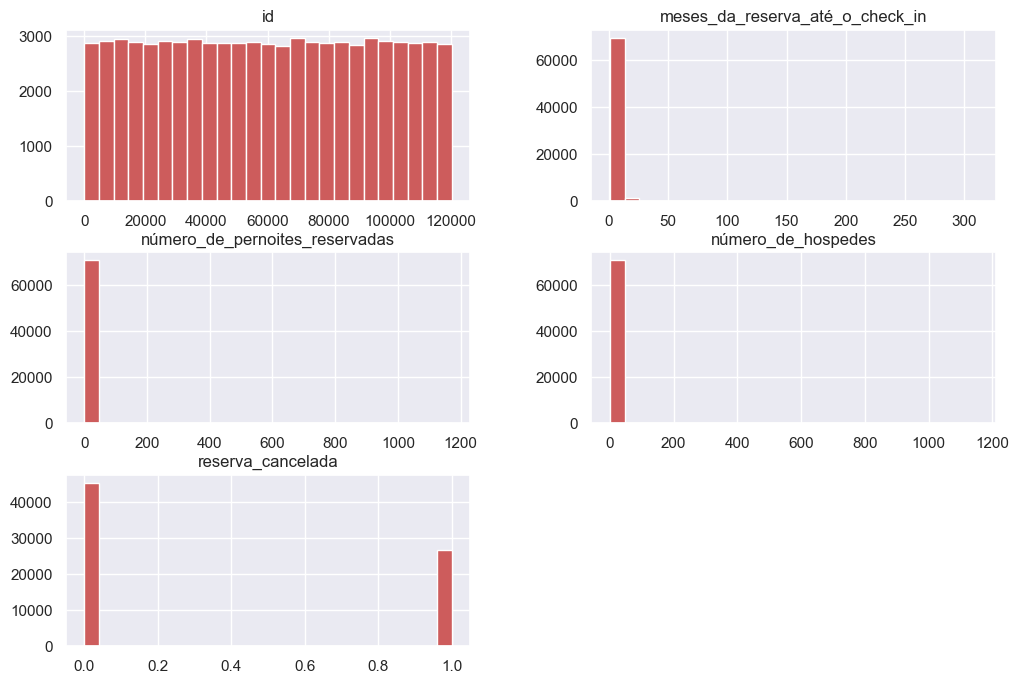

In [12]:
# Gráficos demonstando os dados das variáveis numéricas
plt.figure(figsize = (30,60))
num_attributes.hist(bins= 25, color= 'indianred');

#### Atributos categóricos

In [13]:
# Conta a quantidade de valores únicos em cada coluna de um DataFrame com variáveis categóricas.
cat_attributes.apply(lambda x: x.unique().shape[0])

classificação_do_hotel                    2
regime_de_alimentação                     4
nacionalidade                           170
forma_de_reserva                          3
já_se_hospedou_anterioremente             2
tipo_do_quarto_reservado                 10
reserva_feita_por_agência_de_turismo      2
reserva_feita_por_empresa                 2
reserva_com_estacionamento                2
reserva_com_observações                   3
dtype: int64

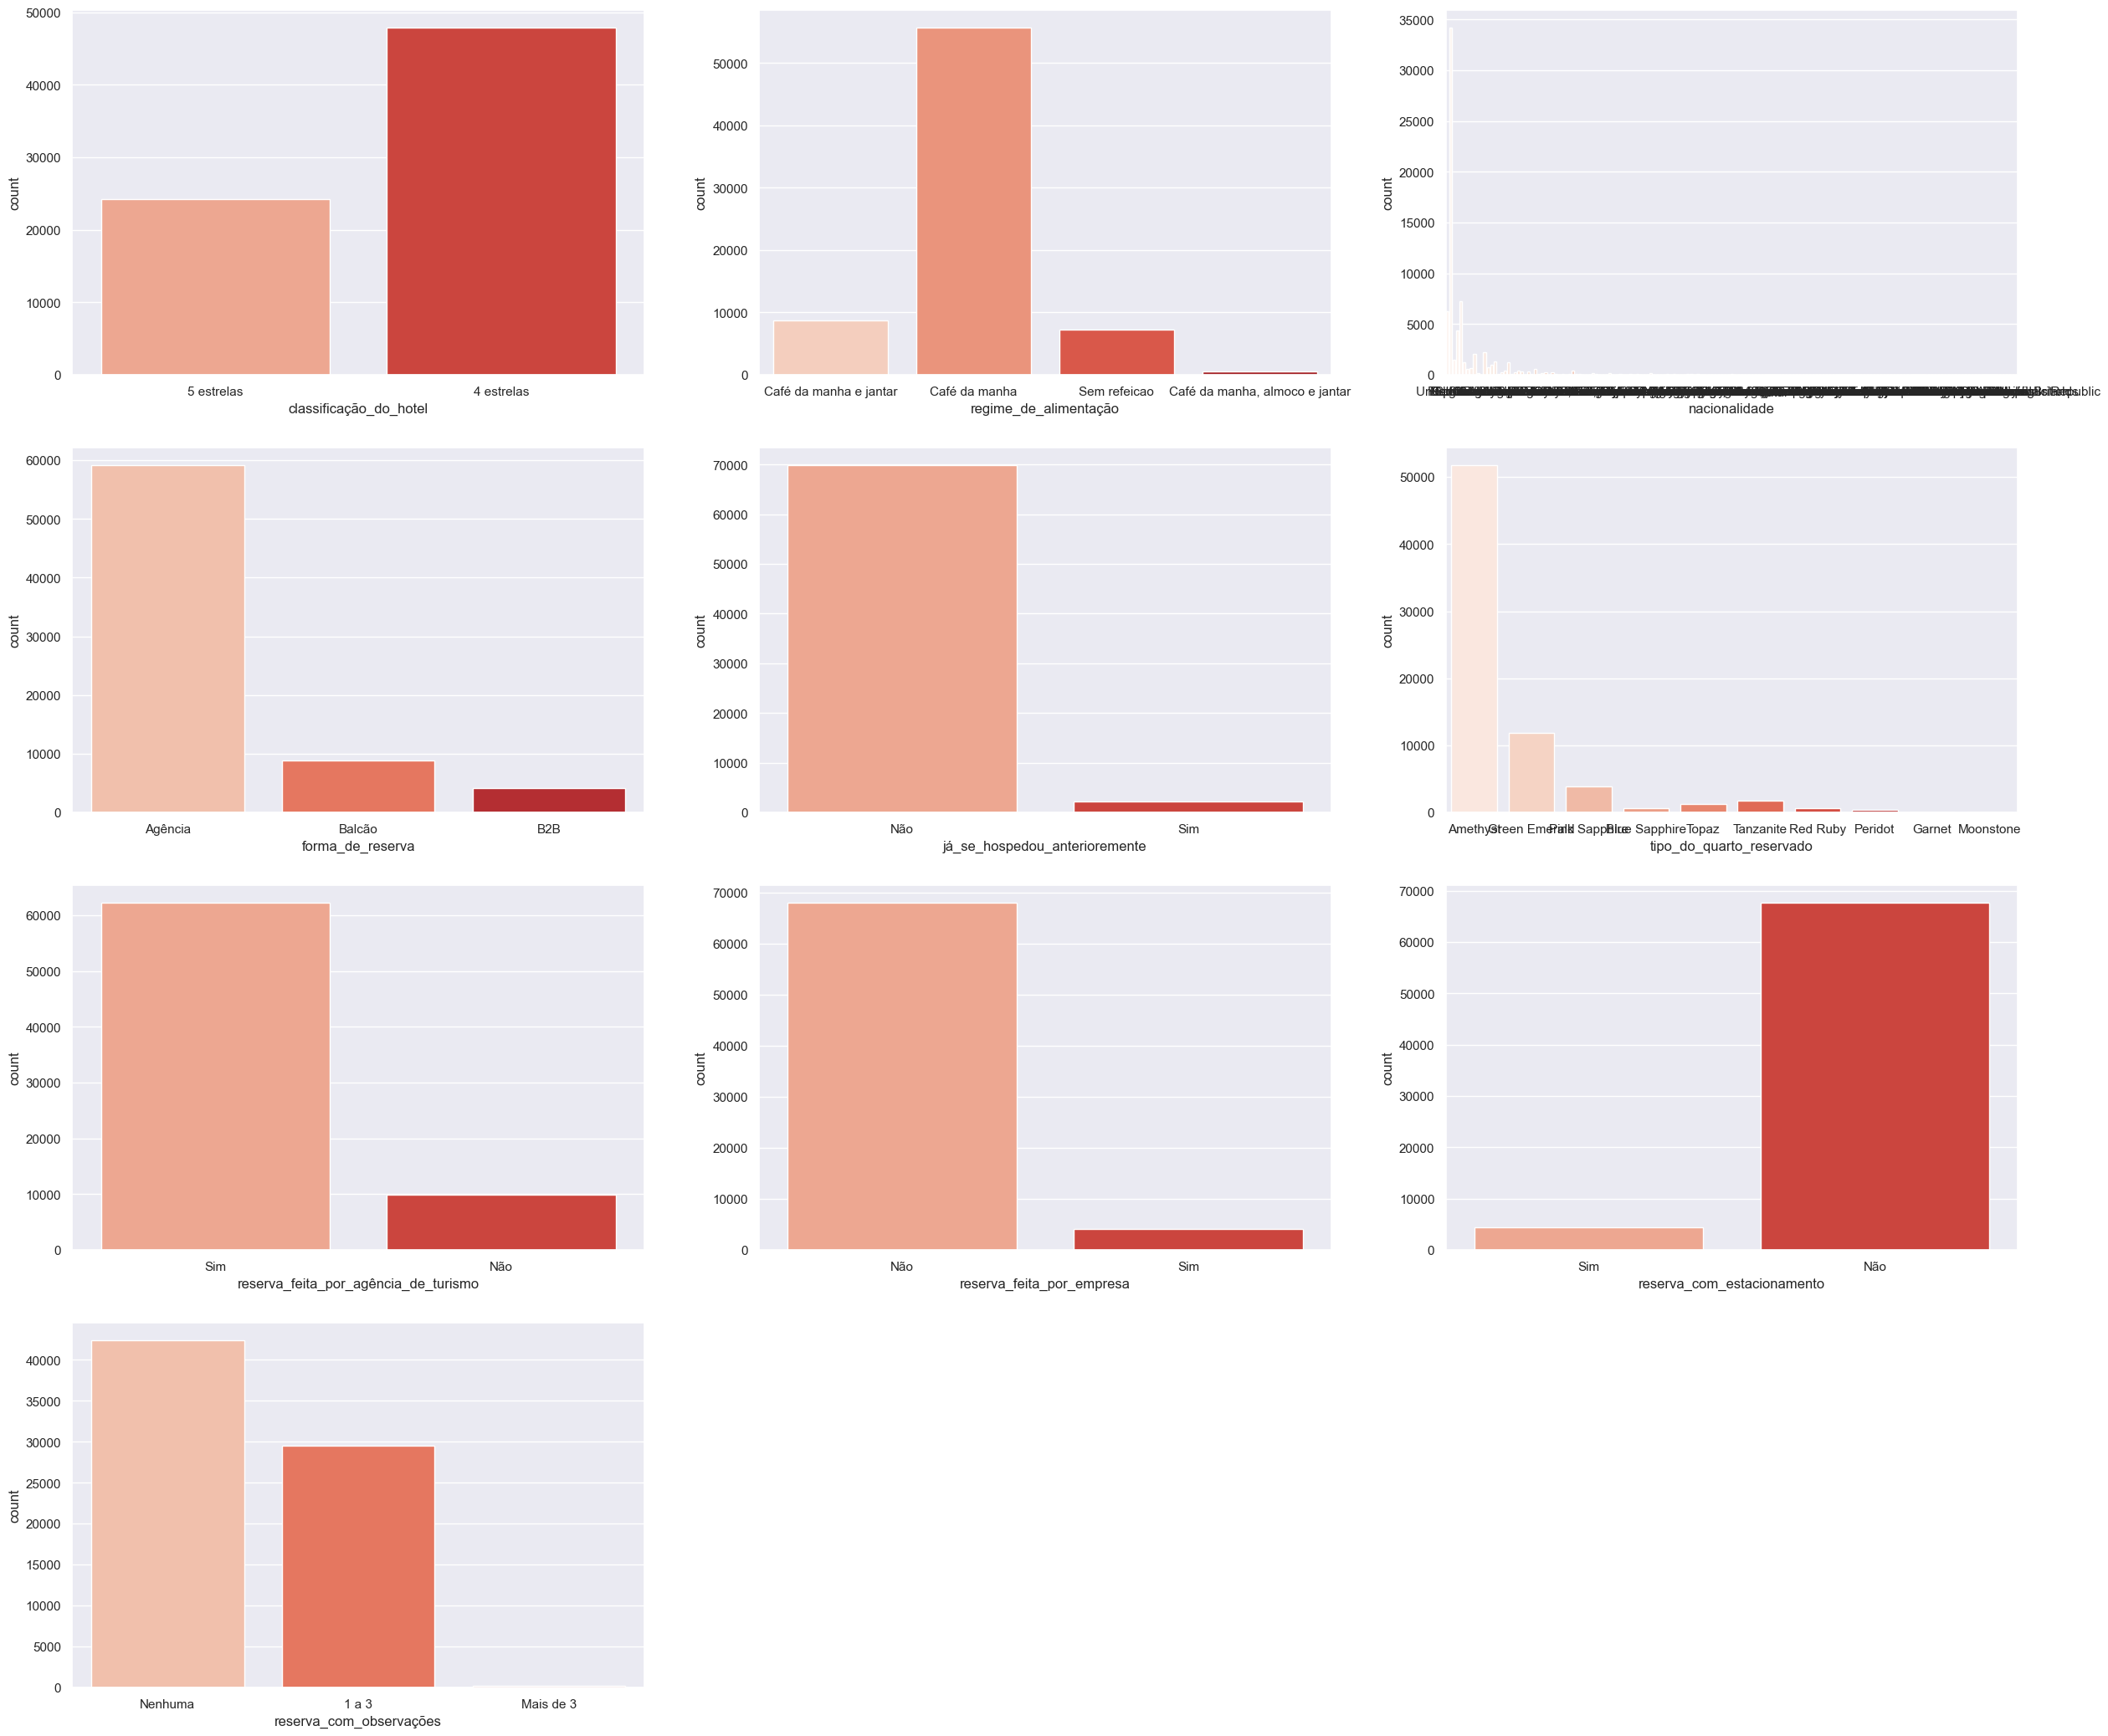

In [14]:
# Plota gráficos de barras para cada variável categórica
plt.figure(figsize = (30,60))

x = 1
for d in cat_attributes:
    plt.subplot(9, 3, x)
    sns.countplot( x=d, data=train, palette = 'Reds')
    x += 1

## FEATURE ENGINEERING

- Taxa de cancelamento por nacionalidade
- Taxa de cancelamento por regime_de_alimentação
- Taxa de cancelamento por tipo_do_quarto_reservado
- Taxa de cancelamento por reserva_com_observações
- Taxa de cancelamento por nacionalidade
- Transformação das variáveis em binárias (Agência, Reserva feita por empresa, Reserva com estacionamento e Classificação do hotel
- Média do id por nacionalidade
- Criação de classes de acordo com o pernoites
- Criação de classes de acordo com o tempo de reserva até o check-in
- Criação de intervalos de id

## EDA

- Levantamento de hipóteses e perguntas de negócio
- Análise univariada para avaliação dos detalhes de cada atributo, incluse a variável target
- Análise bivariada para validação das hipótestes criadas e geração de insights para o negócio

### Análise univariada var resposta

In [16]:
# Calcula a distribuição percentual dos valores únicos da variável 'reserva_cancelada' 
train['reserva_cancelada'].value_counts(normalize=True).reset_index().rename(columns={'index': 'reserva_cancelada', 'reserva_cancelada': 'pctg'})

,reserva_cancelada,pctg
0,0.0,0.629582
1,1.0,0.370418


### Análise bivariada

#### Numéricas

##### H: A safra de clientes tem relação com os cancelamentos

Premissa: Os IDs são sequênciais e contínuos (não aleatórios) ,portanto, tem relação com o tempo

aceita

<AxesSubplot: >

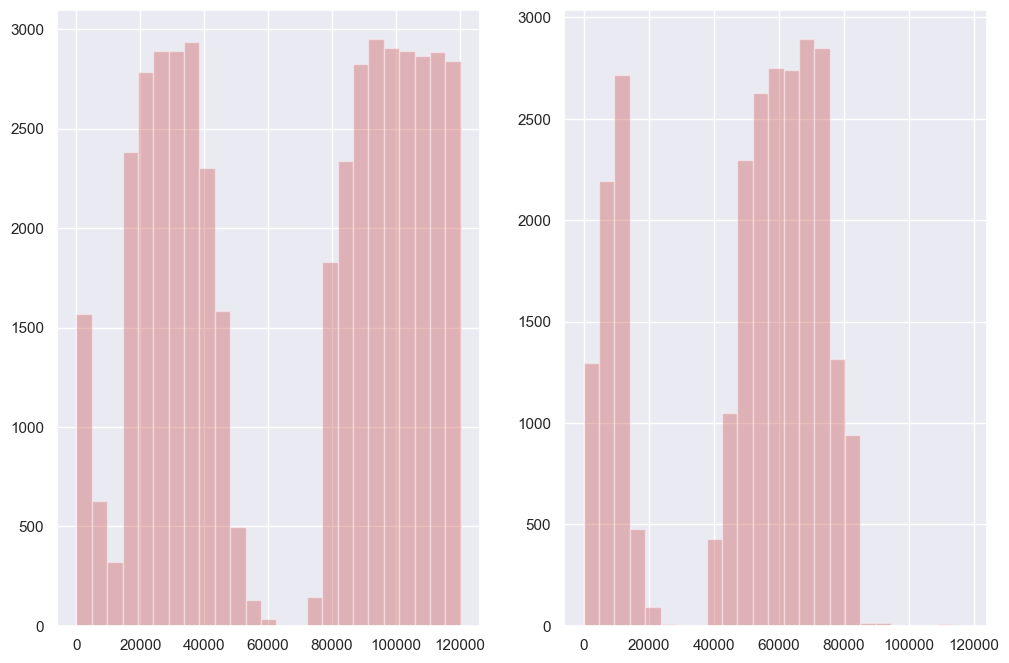

In [17]:
# Gráfico (direita) demonstrando os intervalos quando não há cancelamento
plt.subplot(1, 2, 1)
a1 = train['id'][train['reserva_cancelada']==0]
sns.distplot( x=a1, kde=False, color='indianred', bins=25)

# Gráfico (esquerda) demonstrando os intervalos quando há cancelamento
plt.subplot(1, 2, 2)
a2 = train['id'][train['reserva_cancelada']==1]
sns.distplot( x=a2, kde=False, color='indianred', bins=25)

**INSIGHT:**
Percebe-se que os IDs de 1 a 20000 e de 50000 a 80000 são os intervalos com maior quantidade de cancelamentos, acreditamos que pode estar diretamente relacionado a pandemia do Covid-19, períodos em que houve aumento de restrições, ou outros fatores externos que podem ter ocasionado no cancelamento de viagens e impactando nos números do Hotel.

##### H: Clientes com reservas feitas com um período muito longo, cancelam mais
aceita

<AxesSubplot: >

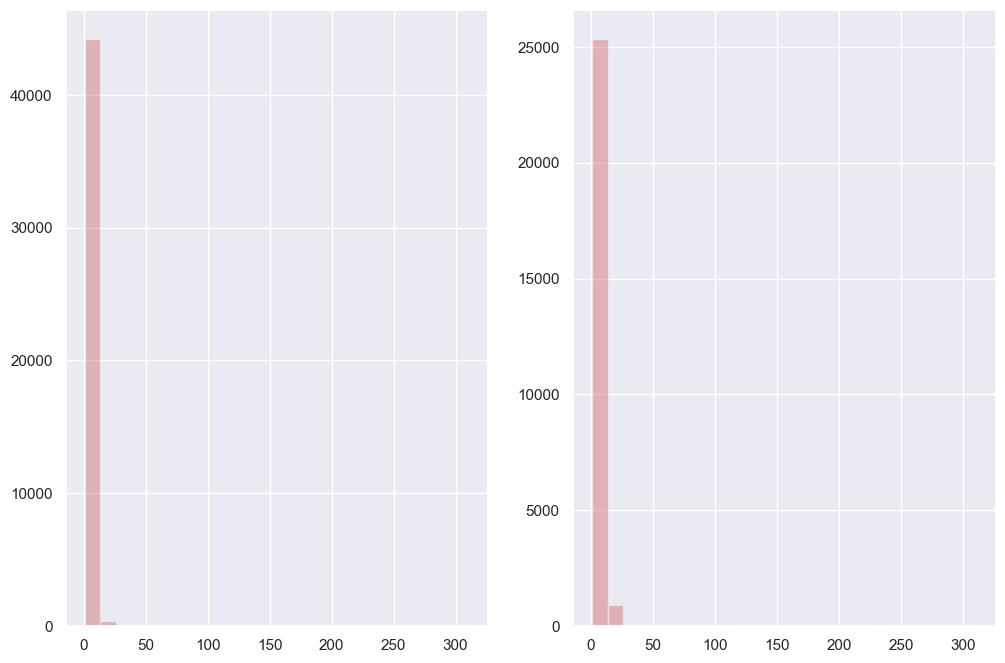

In [18]:
# Análise da variável meses_da_reserva_até_o_check_in quando não há cancelamento da reserva
plt.subplot(1, 2, 1)
a1 = train['meses_da_reserva_até_o_check_in'][train['reserva_cancelada']==0]
sns.distplot( x=a1, kde=False, color='indianred', bins=25)

# Análise da variável meses_da_reserva_até_o_check_in quando há cancelamento da reserva
plt.subplot(1, 2, 2)
a2 = train['meses_da_reserva_até_o_check_in'][train['reserva_cancelada']==1]
sns.distplot( x=a2, kde=False, color='indianred', bins=25)

<AxesSubplot: xlabel='reserva_cancelada', ylabel='meses_da_reserva_até_o_check_in'>

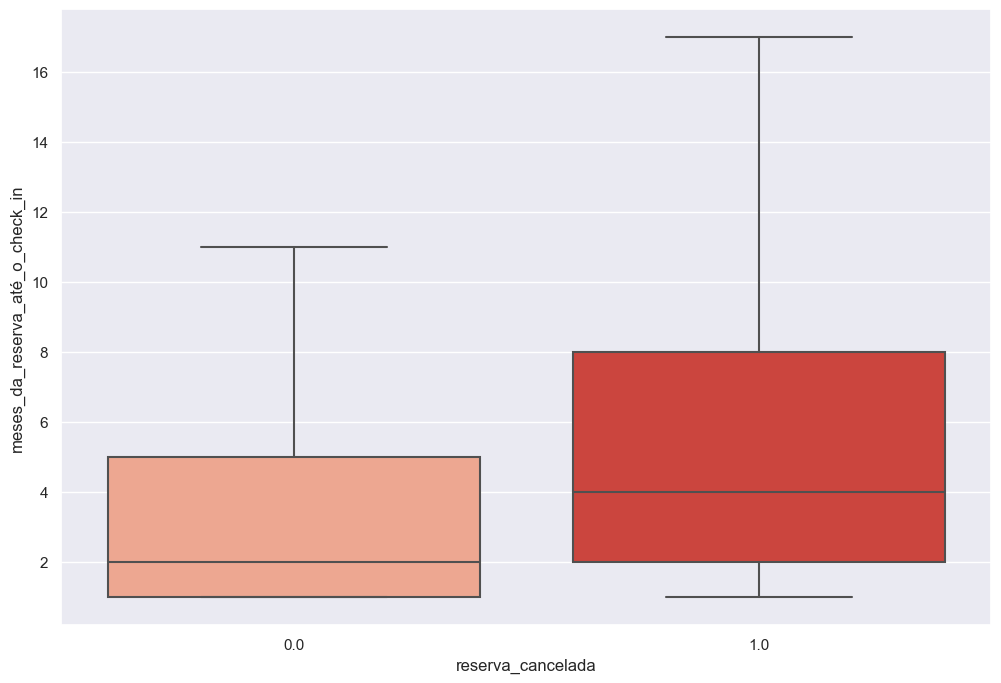

In [19]:
# Analisa a relação entre as variáveis meses_da_reserva_até_o_check_in e reserva cancelada, demonstando os quartis.
sns.boxplot( x=train['reserva_cancelada'], y=train['meses_da_reserva_até_o_check_in'], data=train, palette = 'Reds', showfliers=False)

**INSIGHT:**
Visualmente, os clientes que cancelam o agendamento tem os valores de tempo da reserva até o check-in maior. Com isso, podem ser feitas ações com o time de marketing (comunicações) para manter o engajamento desses clientes.

##### H: Quanto menor o número de pernoites, menor a quantidade de cancelamentos
recusada

<AxesSubplot: >

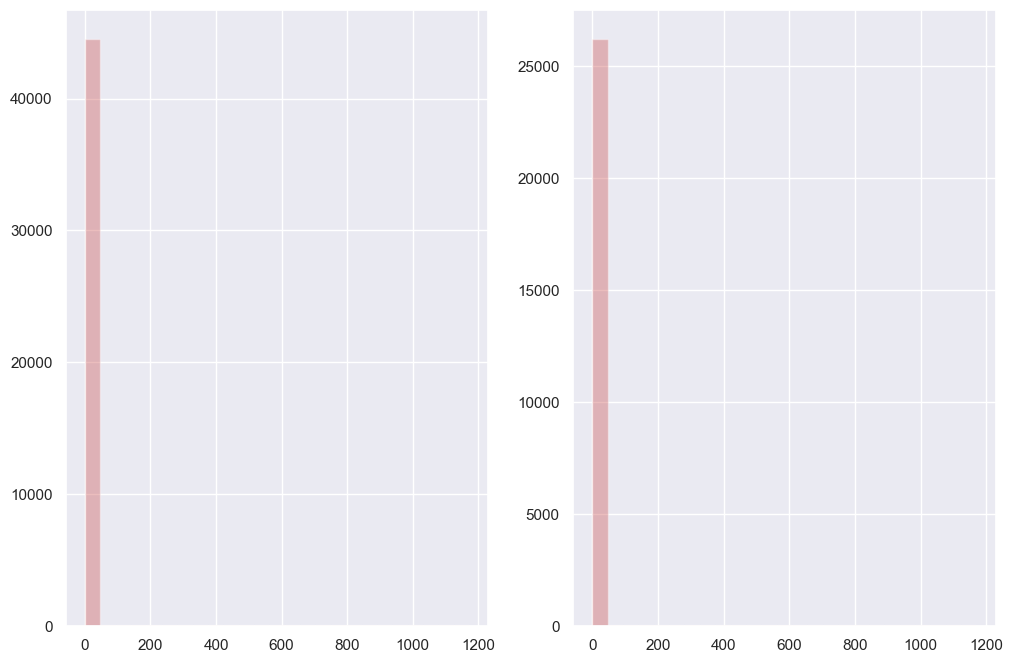

In [20]:
# Análise da variável número_de_pernoites_reservadas quando não há cancelamento da reserva
plt.subplot(1, 2, 1)
a1 = train['número_de_pernoites_reservadas'][train['reserva_cancelada']==0]
sns.distplot( x=a1, kde=False, color='indianred', bins=25)

# Análise da variável número_de_pernoites_reservadas quando há cancelamento da reserva
plt.subplot(1, 2, 2)
a2 = train['número_de_pernoites_reservadas'][train['reserva_cancelada']==1]
sns.distplot( x=a2, kde=False, color='indianred', bins=25)

<AxesSubplot: xlabel='reserva_cancelada', ylabel='número_de_pernoites_reservadas'>

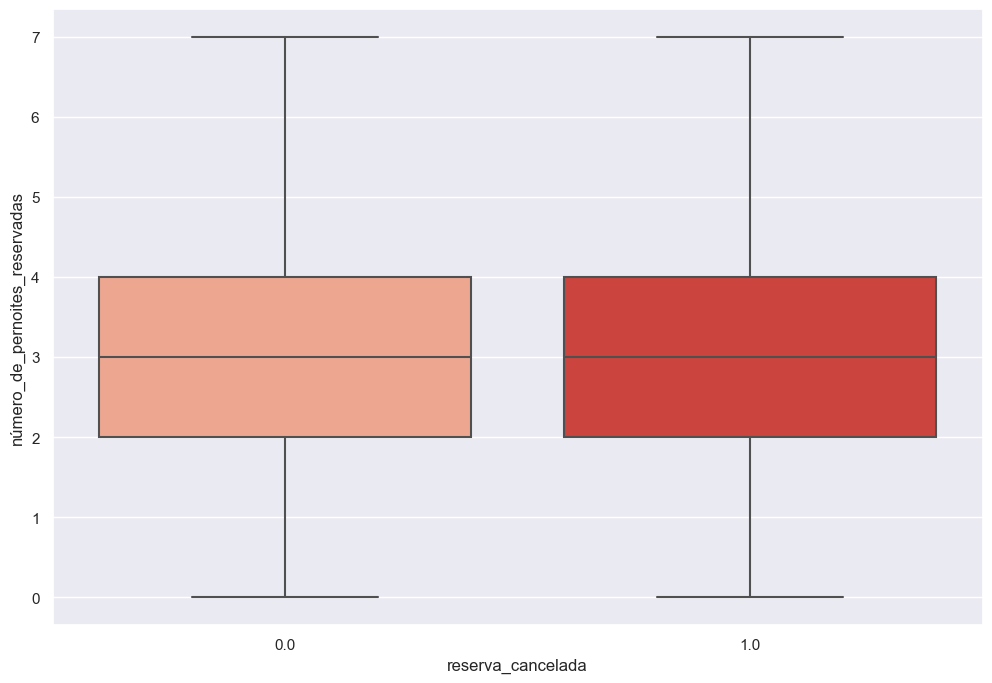

In [21]:
# Analisa a relação entre as variáveis número_de_pernoites_reservadas e reserva cancelada, demonstando os quartis.
sns.boxplot( x=train['reserva_cancelada'], y=train['número_de_pernoites_reservadas'], data=train, palette = 'Reds', showfliers=False)

##### H: Quanto maior o número de hóspedes, menor a quantidade de cancelamentos (eventos/reservas por empresa?)
recusada

In [1]:
# Análise da variável número_de_hospedes quando não há cancelamento da reserva
plt.subplot(1, 2, 1)
a1 = train['número_de_hospedes'][train['reserva_cancelada']==0]
sns.distplot( x=a1, kde=False, color='indianred', bins=25)

# Análise da variável número_de_hospedes quando há cancelamento da reserva
plt.subplot(1, 2, 2)
a2 = train['número_de_hospedes'][train['reserva_cancelada']==1]
sns.distplot( x=a2, kde=False, color='indianred', bins=25)

NameError: name 'plt' is not defined

<AxesSubplot: xlabel='reserva_cancelada', ylabel='número_de_hospedes'>

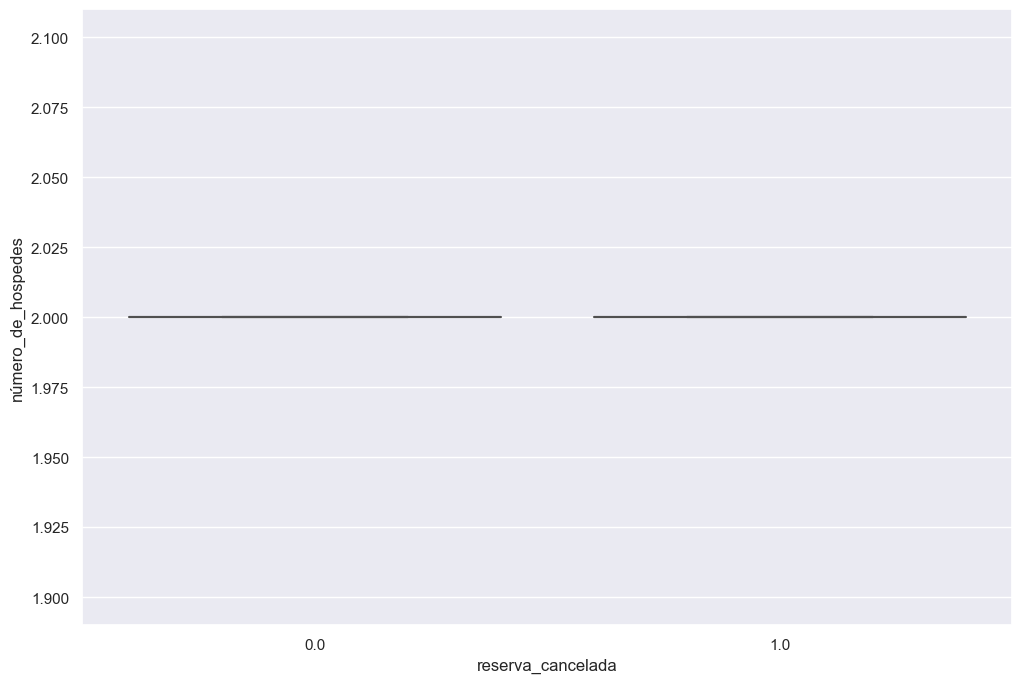

In [23]:
sns.boxplot( x=train['reserva_cancelada'], y=train['número_de_hospedes'], data=train, palette = 'Reds', showfliers=False)

#### Categóricas

In [24]:
# Relacionamento das variáveis categóricas com a reserva cancelada, mostrando os percentuais.
for col in cat_attributes.columns:
    display(pd.crosstab(train[col], train['reserva_cancelada'], normalize='index'))

reserva_cancelada,0.0,1.0
classificação_do_hotel,,
4 estrelas,0.58373,0.41627
5 estrelas,0.72014,0.27986


reserva_cancelada,0.0,1.0
regime_de_alimentação,,
Café da manha,0.627073,0.372927
Café da manha e jantar,0.655919,0.344081
"Café da manha, almoco e jantar",0.398323,0.601677
Sem refeicao,0.632216,0.367784


reserva_cancelada,0.0,1.0
nacionalidade,,
Albania,1.000000,0.000000
Algeria,0.740741,0.259259
American Samoa,1.000000,0.000000
Andorra,0.000000,1.000000
Angola,0.392694,0.607306
Anguilla,1.000000,0.000000
Antarctica,1.000000,0.000000
Argentina,0.736434,0.263566
Armenia,1.000000,0.000000


reserva_cancelada,0.0,1.0
forma_de_reserva,,
Agência,0.589758,0.410242
B2B,0.778821,0.221179
Balcão,0.826126,0.173874


reserva_cancelada,0.0,1.0
já_se_hospedou_anterioremente,,
Não,0.622509,0.377491
Sim,0.848539,0.151461


reserva_cancelada,0.0,1.0
tipo_do_quarto_reservado,,
Amethyst,0.608927,0.391073
Blue Sapphire,0.658247,0.341753
Garnet,0.000000,1.000000
Green Emerald,0.680370,0.319630
Moonstone,1.000000,0.000000
Peridot,0.566489,0.433511
Pink Sapphire,0.713048,0.286952
Red Ruby,0.664921,0.335079
Tanzanite,0.703704,0.296296


reserva_cancelada,0.0,1.0
reserva_feita_por_agência_de_turismo,,
Não,0.753723,0.246277
Sim,0.609909,0.390091


reserva_cancelada,0.0,1.0
reserva_feita_por_empresa,,
Não,0.617807,0.382193
Sim,0.825354,0.174646


reserva_cancelada,0.0,1.0
reserva_com_estacionamento,,
Não,0.60522,0.39478
Sim,1.00000,0.00000


reserva_cancelada,0.0,1.0
reserva_com_observações,,
1 a 3,0.780550,0.219450
Mais de 3,0.915929,0.084071
Nenhuma,0.522847,0.477153


##### H: Reservas que possuem observações tem uma taxa de cancelamento menor
aceita

In [26]:
# Relacionamento da variável 'reserva_com_observações' com todos os dados
display(train.loc[:,['reserva_com_observações']].value_counts(normalize=True))

# Relacionamento da variável 'reserva_com_observações' apenas para as observações em que a reserva é cancelada
display(train.loc[train['reserva_cancelada']==1,['reserva_com_observações']].value_counts(normalize=True))

reserva_com_observações
Nenhuma                    0.587467
1 a 3                      0.409401
Mais de 3                  0.003132
dtype: float64

reserva_com_observações
Nenhuma                    0.756744
1 a 3                      0.242546
Mais de 3                  0.000711
dtype: float64

**INSIGHT**: Cerca de 75% das reservas canceladas não tem observação
- As reservas sem observação representa o maior volume (60%) e elas representam 75% dos cancelamentos. Está informação evidência a necessidade de realizar ações para manter o engajamento deste público com sua reserva.

##### H: A maior taxa de cancelamentos são de países de fora da Europa

In [27]:
# Agrupa a coluna 'nacionalidade' pela coluna 'reserva_cancelada' e calcula a contagem normalizada dos valores mais frequentes
train.loc[train['reserva_cancelada']==1,['nacionalidade','reserva_cancelada']].groupby('reserva_cancelada'
                                                             ).value_counts(normalize=True).head(20)*100

reserva_cancelada  nacionalidade     
1.0                Spain                 67.034831
                   United Kingdom         5.571472
                   France                 4.357660
                   Italy                  2.891285
                   Germany                2.800814
                   Ireland                1.884801
                   Brazil                 1.858414
                   United States          1.119572
                   Belgium                1.096954
                   China                  1.055489
                   Switzerland            0.916013
                   Netherlands            0.889626
                   Russia                 0.557901
                   Russian Federation     0.550362
                   Sweden                 0.542823
                   Austria                0.516435
                   Angola                 0.501357
                   Poland                 0.493818
                   Israel                 0.

In [28]:
# Lista de países/regiões na Europa
top_europa = ['Spain', 'United Kingdom', 'France', 'Italy']

In [31]:
# Cruzamento da frequência de nacionalidades de acordo com a lista de países/regiões da Europa
display(pd.crosstab(train['nacionalidade'].isin(top_europa), train['reserva_cancelada'], normalize='index'))

reserva_cancelada,0.0,1.0
nacionalidade,,
False,0.750214,0.249786
True,0.575981,0.424019


**INSIGHT:** 80% dos cancelamentos estão concentrados nas nacionalidades Spain (67%), United Kingdom(6%), France(4) e Italy(3%). Esta informação possibilita focar as ações de comunicação e ações para as nacionalidades com maiores percentuais de cancelamento.

##### H: Reservas feitas com estacionamento possuem uma taxa de cancelamento menor

In [32]:
# Distribuição de frequência da variável reserva_com_estacionamento
train.loc[:,['reserva_com_estacionamento']].value_counts(normalize=True) 

reserva_com_estacionamento
Não                           0.938289
Sim                           0.061711
dtype: float64

In [33]:
# Contagem de reservas canceladas e não canceladas de acordo com a presença ou não de estacionamento.
display(pd.crosstab(train['reserva_com_estacionamento'], train['reserva_cancelada'], normalize='index'))

reserva_cancelada,0.0,1.0
reserva_com_estacionamento,,
Não,0.60522,0.39478
Sim,1.00000,0.00000


**INSIGHT:** Das reservas que solicitaram vagas de garagem não houve nenhum cancelamento. Eles representam apenas 6% das reservas. Está informação é importante para destacar este atributo dos hotéis e atrair mais o publico deste perfil.

##### H: Existe diferença na eficiência das formas de reserva. Canais que possuem taxa menor de cancelamento do que outros

In [35]:
# Tabelas com a distribuição da variável número de hóspedes para as três formas de reserva.
display(train.loc[train['forma_de_reserva']=='Agência',['forma_de_reserva','número_de_hospedes']].groupby('forma_de_reserva'
                                                             ).value_counts(normalize=True).head(5))
display(train.loc[train['forma_de_reserva']=='Balcão',['forma_de_reserva','número_de_hospedes']].groupby('forma_de_reserva'
                                                             ).value_counts(normalize=True).head(5))
display(train.loc[train['forma_de_reserva']=='B2B',['forma_de_reserva','número_de_hospedes']].groupby('forma_de_reserva'
                                                             ).value_counts(normalize=True).head(5))

forma_de_reserva  número_de_hospedes
Agência           2.0                   0.710275
                  1.0                   0.146679
                  3.0                   0.088541
                  4.0                   0.032364
                  0.0                   0.001217
dtype: float64

forma_de_reserva  número_de_hospedes
Balcão            2.0                   0.611614
                  1.0                   0.206475
                  3.0                   0.105049
                  4.0                   0.049921
                  5.0                   0.004641
dtype: float64

forma_de_reserva  número_de_hospedes
B2B               1.0                   0.678950
                  2.0                   0.280347
                  3.0                   0.013969
                  0.0                   0.003854
                  4.0                   0.001204
dtype: float64

**INSIGHT:** Na forma Agência mais de 85% das reservas são para até duas pessoas. Esse formato se repete para Balcão (80%) e B2B (85%). Um ponto de atenção é que para B2B o maior percentual (67%) é para até 1 hospede. Está informação possibilita criar ações de comunicação e promoções com foco neste perfil de reserva.

### Análise multivariada

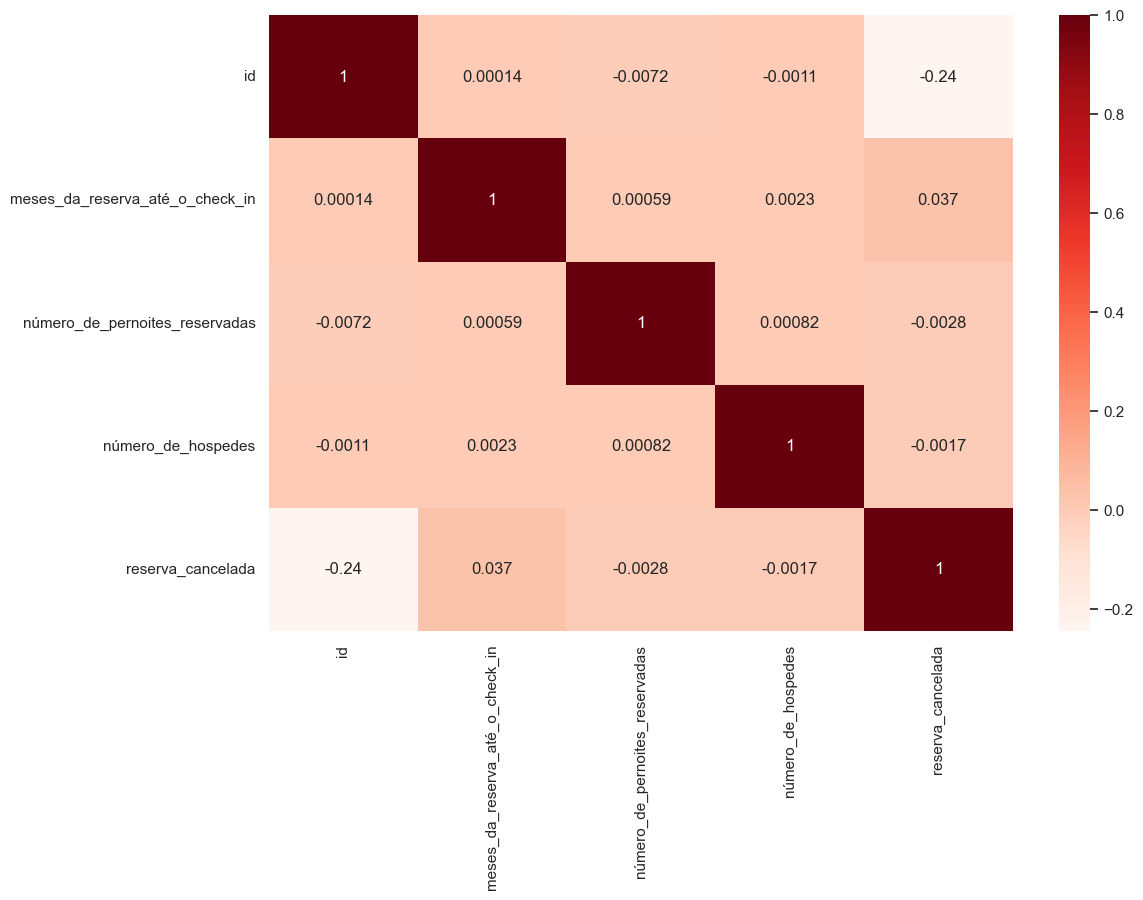

In [14]:
# Gráfico de correlação das variáveis numéricas
correlation = num_attributes.corr(method='pearson')

sns.heatmap(correlation, annot=True, cmap='Reds');

## Pré processamento dos dados

**Númericas:**
- MinMaxScaler
- StandardScaler
- RobustScaler
- PowerTransformer
- Log
    
**Categóricas:**
- CountEncoder
- BinaryEncoder 
- TargetEncoder 
- LabelEncoder 
- OrdinalEncoder
- OneHotEncoder
    
**Númericas e categóricas:**
- MinMaxScaler

### Separação das variáveis explicativas e da variável resposta

In [24]:
# Separação da variável alvo (reserva cancelada) dos dados de treino.
X_train = train.drop(columns=['reserva_cancelada'])
y_train = train['reserva_cancelada']

### Variáveis numéricas

#### Robust Scaler

In [25]:
# Seleção apenas das variáveis numéricas
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

In [26]:
# Ajuste da escala das variáveis numéricas, utilizando um encoder menos sensível a outliers.
rs = RobustScaler()

rs.fit(X_train[numeric_cols])
X_train[numeric_cols] = rs.transform(X_train[numeric_cols])

### Variáveis categóricas

#### Count Encoder

In [27]:
# Seleção apenas das variáveis categóricas
cat_cols = X_train.select_dtypes(include=['object']).columns

In [28]:
# Transforma as features categoricas em numéricas através do numero de frequencia
count = CountEncoder(cols=cat_cols, return_df=True) 

X_train = count.fit_transform(X_train)

### Fill NA

In [29]:
# Preenche todas os campos que estiverem sem dado pelo número 0
X_train = X_train.fillna(0)

## SELEÇÃO DE VARIÁVEIS

- Seleção das variáveis mais importantes, que explicam mais o fenômeno de cancelamento a partir do feature importance de um alguma de árvore

In [30]:
# definição do modelo
trees = ExtraTreesClassifier(n_estimators=250, random_state=42, n_jobs=-1)

trees.fit(X_train, y_train)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=42)

Feature ranking:
                                feature  importance
0                                    id    0.574063
0                         nacionalidade    0.100953
0       meses_da_reserva_até_o_check_in    0.064614
0        número_de_pernoites_reservadas    0.041976
0               reserva_com_observações    0.041493
0                classificação_do_hotel    0.040511
0            reserva_com_estacionamento    0.032049
0                      forma_de_reserva    0.027909
0                    número_de_hospedes    0.020817
0                 regime_de_alimentação    0.018479
0              tipo_do_quarto_reservado    0.017051
0  reserva_feita_por_agência_de_turismo    0.008316
0             reserva_feita_por_empresa    0.006113
0         já_se_hospedou_anterioremente    0.005656


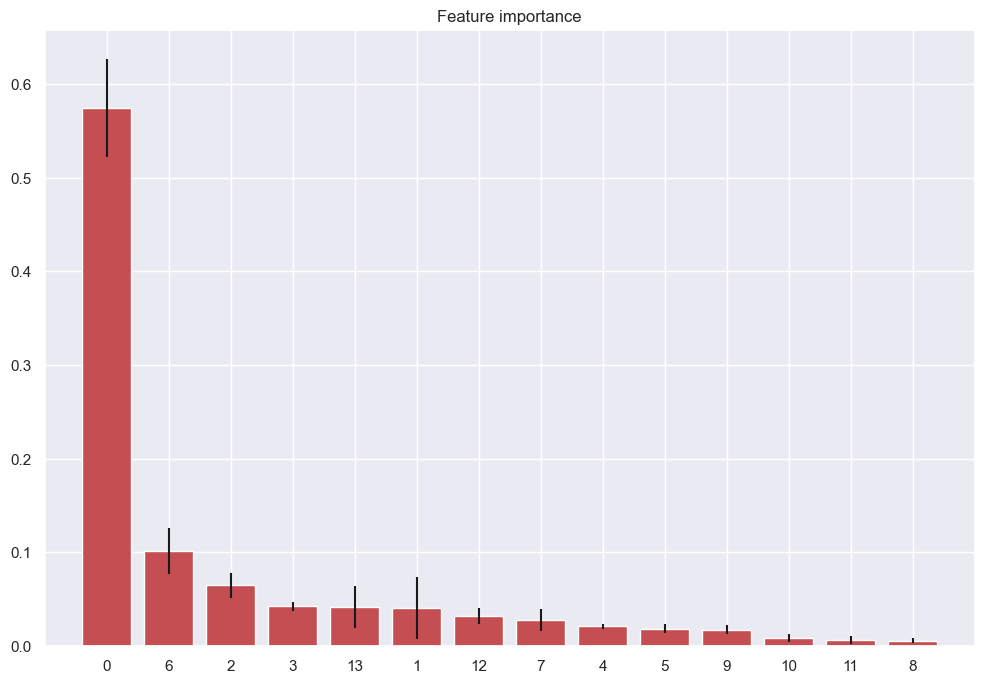

In [31]:
# Análise da importância das features para a predição do modelo
importances = trees.feature_importances_
std = np.std([tree.feature_importances_ for tree in trees.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# ranking de features
print('Feature ranking:')
df = pd.DataFrame()
for i, j in zip(X_train, importances):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)
    
print(df.sort_values('importance', ascending=False))

# Plot feature importance impurity
plt.figure()
plt.title('Feature importance')
plt.bar(range(X_train.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

## MACHINE LEARNING

- Separar dataset "train" em treino e teste
- Aplicação dos algoritmos de classficação: Logistic regression, KNN, Random Forest e XGBoost
- Cálculo do f1-score
- Comparação dos scores de performance
- Escolha do algoritmo

### Treinando Modelo - Logistic Regression

In [ ]:
# inicializando estimador
model = LogisticRegression()

scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro')

print("F1-score Médio:", scores.mean())

### Treinando Modelo - Random Forest

In [32]:
# inicializando estimador
model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro')

print("F1-score Médio:", scores.mean())

F1-score Médio: 0.969269596307624


### Treinando Modelo - KNN

In [33]:
# inicializando estimador
model = KNeighborsClassifier()

scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro')

print("F1-score Médio:", scores.mean())

F1-score Médio: 0.8634095238497727


### Treinando Modelo - XGBOOST

In [36]:
# inicializando estimador
model = xgb.XGBClassifier(objective='binary:logistic',
                        n_estimators=100,
                        eta=0.01,
                        max_depth=10,
                        subsample=0.7,                       
                        colsample_bytree=0.9)

scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro')

print("F1-score Médio:", scores.mean())

F1-score Médio: 0.9652751461199369


## OTIMIZAÇÃO HIPERPARAMETROS

- Fazer otimização dos hiperparâmetos utilizando: RandomizedSearch, GridSearch, Bayes

In [ ]:
# xgb_model = xgb.XGBClassifier(random_state=1, n_jobs=-1)

# params = {
#     'n_estimators': [400, 500, 600],
#     'max_depth': [5, 15, 20],
#     'learning_rate': [0.01, 0.1, 1],
#     'subsample': [0.5, 0.75, 1],
#     'colsample_bytree': [0.5, 0.75, 0.9]
# }

# scorer = make_scorer(f1_score, average='macro')

# random_search = RandomizedSearchCV(
#     estimator=xgb_model,
#     param_distributions=params,
#     scoring=scorer,
#     cv=5,
#     n_iter=3,
#     n_jobs=-1,
#     random_state=42
# )

# random_search.fit(X_preproc, y_train)

### XGB Tunado

In [37]:
# Treinamento do Modelo utilizando o algoritmo XGBoost
xgb = xgb.XGBClassifier(objective='binary:logistic',
                        n_estimators=600,
                        eta=0.01,
                        max_depth=20,
                        subsample=0.75,                       
                        colsample_bytree=0.9,
                        random_state=1)

xgb.fit(X_train, y_train)

scores = cross_val_score(xgb, X_train, y_train, cv=5, scoring='f1_macro')

print("F1-score Médio:", scores.mean())

F1-score Médio: 0.9719804675940431


## MODELO EM PRODUÇÃO

- Aplicar todas as transformações do dataset de treino no de teste e fazer a previsão dos cancelamentos. Exportar os resultados para um csv e fazer o upload no Kaggle.

### Aplicando transformações no teste

In [38]:
# Cópia dos dados de teste
X_test = test.copy()

# Transformação das variáveis numéricas usando o encoder RobustScaler
X_test[numeric_cols] = rs.transform(X_test[numeric_cols])

# Transformação dos dados de teste
X_test = count.transform(X_test)

# Preenche todas os campos que estiverem sem dado pelo número 0
X_test = X_test.fillna(0)

### Predic test

In [39]:
# Aplicação do modelo nos dados de teste para fazer a predição
predicao_xgb = xgb.predict(X_test)

### Solucao Final

In [40]:
# Criação do dataframe que será exportado para o arquivo de submissão
df_final_xgb = pd.concat([test.id, pd.Series(predicao_xgb, name = 'Reserva Cancelada')], axis=1)

df_final_xgb.head()

,id,Reserva Cancelada
0,118345,0
1,9500,1
2,34558,0
3,70816,1
4,105321,0


In [41]:
# Criação do arquivo de submissão com as variáveis ID e Reserva Cancelada
df_final_xgb.to_csv('../outputs/submissao_final.csv', index=False) #Arquivo de submissão pronto para ser enviado.

### Operacionalização

- Arquivo .py para execução automática das previsões baseada em novos inputs

In [ ]:
# Import libs
import pandas                  as pd
import xgboost                 as xgb
from sklearn.ensemble          import RandomForestClassifier
from sklearn.preprocessing     import RobustScaler
from sklearn.model_selection   import cross_val_score
from category_encoders.count   import CountEncoder

# Import Data
def get_data(path_train, path_test):
    # Dados de Treino
    data_train = pd.read_csv(path_train)
    # Dados de Teste
    data_test = pd.read_csv(path_test)
    # Retira a variável alvo
    X_train = data_train.drop(columns=['Reserva Cancelada'])
    # Seleciona somente a variável alvo
    y_train = data_train['Reserva Cancelada']
    # Atribui o dataset de teste
    X_test = data_test.copy()
    
    return X_train, y_train, X_test, data_test
    
def preprocess_data(data):
    # Identificar as colunas numéricas
    numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns
    # Aplicar RobustScaler para transformar os dados numéricos
    rs = RobustScaler()
    rs.fit(data[numeric_cols])
    data[numeric_cols] = rs.transform(data[numeric_cols])
    
    # Identificar as colunas categóricas
    cat_cols = data.select_dtypes(include=['object']).columns
    # Usar CountEncoder para transformar as colunas categóricas em numéricas baseado na frequência
    count = CountEncoder(cols=cat_cols, return_df=True)
    X_preproc = count.fit_transform(data)
    
    # Preencher valores ausentes com 0
    X_preproc = X_preproc.fillna(0)
    
    return X_preproc
    
def train_xgb(X_train_preproc, y_train):
    # Treinamento do Modelo usando o XGBoost
    xgb_model = xgb.XGBClassifier(objective='binary:logistic',
                                    n_estimators = 600,
                                    eta = 0.01,
                                    max_depth = 20,
                                    subsample = 0.75,                       
                                    colsample_bytree = 0.9,
                                    random_state = 1)

    xgb_model.fit(X_train_preproc, y_train)

    return xgb_model

def predict_xgb(model, X_test_preproc):   
    # Fazer a predição com o modelo treinado
    predicao_xgb = model.predict(X_test_preproc)
    
    return predicao_xgb

def score(X_train, y_train, model):
    # Cálculo da métrica F1-Score
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro')
    return print("F1-score Médio:", scores.mean())
    
def export_file(data_test, predicao_xgb):
    # Concatena ID e variável alvo predita
    df_final = pd.concat([data_test.id, pd.Series(predicao_xgb, name = 'Reserva Cancelada')], axis=1)
    
    # Criar DataFrame final com as predições
    df_final.to_csv('submission.csv', index=False)
    
    return print('Arquivo csv criado com sucesso! Boa sorte na submissão!')


if __name__ == "__main__":

    path_train = 'train.csv'
    path_test = 'test.csv'
    X_train, y_train, X_test, data_test = get_data(path_train, path_test)
    X_train_preproc  = preprocess_data(X_train)
    X_test_preproc   = preprocess_data(X_test)
    xgb_model = train_xgb(X_train_preproc, y_train)
    predicao_xgb = predict_xgb(xgb_model, X_test_preproc)
    score(X_train_preproc, y_train, xgb_model)
    export_file(data_test, predicao_xgb)

# Conclusão

- Foram treinados vários algoritmos: XGBoost, SVM, Decision Tree, Random Forest e Logistic Regressor.
- O algoritmo que teve a melhor performance foi o XGBoost
- O resultado da métrica F1-Score foi de 97%
- Esse valor representa um acerto na classificação dos clientes (?)

# Próximos passos

- Apresentar ações sugeridas ao time de Marketing
- Coletar dados de outras fontes (webscrapping)
- Treinar o modelo incluindo os novos dados coletados
- Criar um modelo de ranqueamento, para identificar em real-time a propensão de cancelamento, e ações de MKT sejam executadas antes do cancelamento do cliente.